In [1]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
host = "localhost"
port = "27017"
username = "accretioadmin"
password = "adminaccretio&2017"
authSource = "admin"

In [3]:
def _connect_mongo(db):
    if username and password:
        conn = MongoClient(host=host,
                            port=int(port),
                            username=username,
                            password=password,
                           authSource=authSource)
    else:
        conn = MongoClient(host, port)
        
    return conn[db]    


def read_mongo(db, collection, query={}):
    db = _connect_mongo(db=db)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))
    return df

In [4]:
df = read_mongo("connectTimeline", "post")
df = df[["_id", "registrationNumber","body","attached_file","likes","comments","publish_date"]]
df["registrationNumber"] = df["registrationNumber"].astype(str)
df = df.dropna()

In [5]:
df.at[1,'body']='"<span style=\"background-color: rgb(253, 253, 253);\">Chers Advyteam’iens, Nous cherchons à l’occasion de chaque exercice annuel terminé de faire le bilan qualitatif et quantitatif de nos réalis'
df.at[3,'body']= "https://www.youtube.com/watch?v=eyLS_JX8OMw"
df.at[0,'body']= "On est fier de l'avancement en 2020 👋 👋 💪 continu... "

In [6]:
df.head()

,_id,registrationNumber,body,attached_file,likes,comments,publish_date
0,5bae630cdb5d87000977308d,00115,On est fier de l'avancement en 2020 👋 👋 💪 cont...,aad42685-a1d1-47fd-b592-63bb861b2c1d,"[{'_id': None, 'registrationNumber': '00079', ...",[5bb2973ba5b16a0001ef4ead],2018-09-28 17:20:14.253
1,5bae6c48db5d870009773094,00115,"""<span style=""background-color: rgb(253, 253, ...",4a8776a7-479a-4b41-a1e8-d713ba6eef6a,"[{'_id': None, 'registrationNumber': '00039', ...",[],2018-09-28 17:59:37.501
2,5bae93c1a5b16a0001ef4e4c,00132,Advyteam souhaite la bienvenue à tous ses coll...,8a620e20-e836-4828-92e4-5c1d346989d3,"[{'_id': None, 'registrationNumber': '00132', ...",[],2018-09-28 20:48:01.924
3,5bae9661a5b16a0001ef4e4e,00086,https://www.youtube.com/watch?v=eyLS_JX8OMw,a59ee07e-08b2-459d-a4c1-dcffe4d6101a,"[{'_id': None, 'registrationNumber': '00039', ...",[],2018-09-28 21:00:17.066
4,5bae968aa5b16a0001ef4e51,00086,Accretio passe à la vitesse suivante 🙂,4459d1e2-91aa-488c-aeab-11b71e3efe21,"[{'_id': None, 'registrationNumber': '00024', ...",[5bb24617a5b16a0001ef4e60],2018-09-28 21:00:58.461


In [7]:
import re
import emoji
import spacy
from spacy_lefff import LefffLemmatizer
from spacy.language import Language
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
def remove_emoji(string):
    return emoji.get_emoji_regexp().sub(u'', string)

final_stopwords_list = list(fr_stop) + list(en_stop)
def custom_stopwords(text):
    text = " ".join([w for w in text.split() if w.lower() not in final_stopwords_list])
    text = re.sub(r'<.*?>', '', text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)  
    text = re.sub(r'[^a-zA-Z0-9 àâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔ\'ŒÙÛÜŸÇ]+', '', text)
    text = remove_emoji(text)
    clear_text = " ".join(text.split())
    return clear_text

In [8]:
df["body"] = df["body"].apply(custom_stopwords)

In [9]:
df = df[df['body'].map(len)>1]

In [10]:
nb_word = len(str(df["body"]))

### number of posts

In [11]:
df.shape[0]

744

### number of active employees

In [12]:
len(df['registrationNumber'].unique())

108

### detect used languages

In [13]:
from langdetect import detect

text_posts = df["body"]
langs = [detect(i) for i in text_posts if not i.isnumeric()]
d = dict()

for i in langs:    
    d[f"{i}"] = langs.count(i)    

In [14]:
# not to show
s = 0
d2 = d.copy()
for i ,j in d.items():
    if(i!="en" and i!="fr"):
        s+=j
        d2.pop(i)   
d2["UNKOWN" ] = s - 20     
d2["fr"]+= 20

In [15]:
plt.rcParams["font.size"] = "14"
plt.rcParams["figure.figsize"] = (8,10)

In [16]:
d = d2

Text(0.0, 1.0, 'Languages in Accretio')

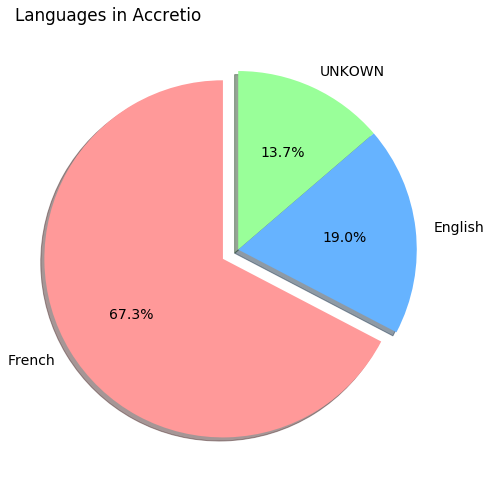

In [17]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0, 0)
plt.pie([float(d[v]) for v in d], labels=["English" if str(k)=="en" else "French" if str(k)=="fr"  else "UNKOWN"  for k in d], autopct='%1.1f%%', colors=colors, shadow=True, startangle=90, explode=explode)
plt.title('Languages in Accretio', loc='left')

## special characters (emojis, links...)

### Number of words distribution

In [18]:
df['word_count'] = df['body'].astype(str).apply(len)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [20]:
df['word_count'].iplot(
    kind='line',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Post Text Word Count Distribution')

In [25]:
avg = df["word_count"].mean()
maxi = df["word_count"].max()
mini = df["word_count"].min()

In [26]:
print(avg)
print(maxi)
print(mini)

80.64381720430107
1283
2


## Sentiment analysis

In [27]:
from textblob import TextBlob

In [28]:
df['sentiment'] = df['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [29]:
df['sentiment'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

### Part-of-speech taging

In [30]:
blob = TextBlob(str(df['body']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for post corpus')

In [31]:
def count_words(txt):
    return len(txt.strip().split())

# Pourcentage Misspelled words

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
misspelled = len([i for i in spell.unknown(str(df["body"]).lower().split())])
nb_posts_total_words = count_words(str(df["body"]))

In [ ]:
pourcentage_of_miss_words = misspelled/nb_posts_total_words*100

In [ ]:
print(f"{pourcentage_of_miss_words}% of words are misspelled")

In [ ]:
len(str(df["body"]))

In [ ]:
misspelled

In [ ]:
misspelled = spell.unknown(['something', 'is', 'hapenning', '?',"http"])